In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

select u from random distribution 0~1

In [2]:
from scipy.stats import truncnorm
# normal distribution 0~1
lower, upper = 0, 1
mu, sigma = 0.5, 0.2
distribution = truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

functions

In [3]:
def calculate_obj(b, Beta, u, n):
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i

    obj = np.sum(p * np.log(p/Beta)) - np.sum(b * np.log(u)) + np.sum(p * np.log(p / q))

    return obj 

def update_b(b, Beta, u, grad_b_history, learning_rate, n):
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i

    grad_b_term1 = np.array([[np.log(p[j]/Beta[j])+1 for j in range(n)] for i in range(n)] )
    grad_b_term2 = -np.log(u)
    grad_b_KL_term = np.array([[0.0]*n for i in range(n)])
    for i in range(n):
        for j in range(n):
            if i==j:
                grad_b_KL_term[i][j] = np.log(p[j]/q[j]) + ((q[j]-b[i][j])-(p[j]-b[i][j]) )/q[j] 
            else:
                grad_b_KL_term[i][j] = -p[i]/q[i] + 1 + np.log(p[j]/q[j]) 

    grad_b = grad_b_term1 + grad_b_term2 + grad_b_KL_term

    learning_rate = learning_rate
    # GD
    b = b - learning_rate * grad_b
    # b_{ij} >= 0
    b = np.where(b<0, 0, b)

    grad_b_history.append(grad_b)
    
    return b


def update_Beta(Beta, b, u, grad_Beta_history, learning_rate, n):
    p = np.sum(b, axis=0)
    grad_Beta = np.array([-p[j]/Beta[j] for j in range(n)])
    learning_rate = learning_rate
    # GD
    Beta = Beta - learning_rate * grad_Beta
    # Beta_i >= 0
    Beta = np.where(Beta<0, 0, Beta)
    # Beta_i <= p_j/u_{ij}
    for i in range(len(Beta)):
        if Beta[i]<=np.min([p[j]/u[i][j] for j in range(n)]):
            pass
        else:
            Beta[i] = np.min([p[j]/u[i][j] for j in range(n)])

    grad_Beta_history.append(grad_Beta)

    return Beta
    
def calculate_p_q(b):
    # constraint: sumj bij = q
    q = np.sum(b, axis=1)
    # constraint: sumi bij = p
    p = np.sum(b, axis=0) 

    return p, q

def vec2simple(vec,l):
    m = len(vec)
    vecS = np.sort(vec)[::-1]
    vecC = np.cumsum(vecS) - l
    vecH = vecS - vecC / (np.arange(m)+1)

    r = np.max(np.where(vecH>0)[0])
    t = vecC[r] / (r+1)

    return np.maximum(0, vec - t)

def project_q(q, b, n):
    for i in range(n):
        if q[i]>=1:
            pass
        else:
            b[i] = vec2simple(b[i],1)
            q[i] = np.sum(b[i])
    return b


def project_p(p, b, n):
    for i in range(n):
        if p[i]>=1:
            pass
        else:
            b.T[i] = vec2simple(b.T[i],1)
            p[i] = np.sum(b.T[i])
    return b

main function

In [4]:
def start_experiment(T, learning_rate, u, n):
    '''
    Parameters
    ----------
        T: iterations
        learning_rate: stepsize
        u: (int)random_state, (ndarray)input array
        n: number of agents
    
    Return
    ------
        result: experiment results
    '''

    if type(u)==int:
        random_state = u
        u = distribution.rvs((n,n),random_state=random_state)
    elif type(u)==np.ndarray:
        random_state = 'given'
        u = u
    else:
        print('Not a valid input u')

    for t in range(T):  
        if t==0:     
            b_history = []
            b = np.full((n,n),1/n)    
            b_history.append(b)

            q_history = []
            p_history = []
            q = np.sum(b, axis=1)
            p = np.sum(b, axis=0)
            q_history.append(q)
            p_history.append(p)

            Beta_history = []
            Beta=np.full(n,1.0)
            Beta_history.append(Beta)

            obj_history = []
            obj = calculate_obj(b, Beta, u, n)
            obj_history.append(obj)
            avg_obj_history = [obj]
            
            grad_b_history = [np.zeros((n,n))]
            grad_Beta_history = [np.zeros(n)]

            kl_history = [np.sum(p * np.log(p / q))]
            
        else: 
            b = update_b(b, Beta, u, grad_b_history, learning_rate, n)
            p, q = calculate_p_q(b)

            b = project_q(q, b, n)
            p, q = calculate_p_q(b)
            b = project_p(p, b, n)
            p, q = calculate_p_q(b)
            b_history.append(b)
            q_history.append(q)
            p_history.append(p)

            Beta = update_Beta(Beta, b, u, grad_Beta_history, learning_rate, n)
            Beta_history.append(Beta)
  
            obj = calculate_obj(b, Beta, u, n)
            obj_history.append(obj)
            avg_obj_history.append((avg_obj_history[-1] * len(avg_obj_history) + obj)/(len(avg_obj_history)+1))

            kl_history.append(np.sum(p * np.log(p / q)))

    result = {
        'T': T,
        'lr': learning_rate,
        'n': n,
        'u': u,
        'random_state': random_state,
        'objective': obj_history[-1],
        'min_obj': np.min(obj_history),
        'obj_history': obj_history,
        'avg_obj_history': avg_obj_history,
        'b_history': b_history,
        'Beta_history': Beta_history,
        'q_history': q_history,
        'p_history': p_history,
        'grad_b_history': grad_b_history,
        'grad_Beta_history': grad_Beta_history,
        'kl_history': kl_history
        
    }
    # save to pickle for reuse
    with open('experiment/KL_BCGP/n_{}_u_{}_lr{}_iter{}.pickle'.format(n,random_state,learning_rate,T), 'wb') as f:
        pickle.dump(result, f)

    return result
    


draw plt functions

In [5]:
def draw_obj_plt(result):
    # plot obj curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    t = range(T)
    plt.plot(t, result['obj_history'], label='obj', c='b')
    plt.plot(t, result['avg_obj_history'], label='average_obj', c='r')
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    # plt.scatter(t[-1], result['objective'], c='y', label='obj={}'.format(result['objective']))
    # plt.scatter(np.argmin(result['obj_history']), np.min(result['obj_history']), c='g', label='min={}\n t={}'.format(np.min(result['obj_history']), np.argmin(result['obj_history'])))
    plt.title('KL_BCGP n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.xlabel('t')
    plt.ylabel('obj')
    plt.legend()
    plt.savefig('experiment/KL_BCGP/obj/KL_BCGP_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

def draw_multiple_obj_plt(result1, result2, result3):
    # plot obj curve
    T = result1['T']
    learning_rate = result1['lr']
    random_state = result1['random_state']
    n = result1['n']

    t = range(T)
    plt.plot(t, result1['obj_history'], label='Orig BCGP obj', c='c')
    plt.plot(t, result2['obj_history'], label='KL BCGP obj', c='y')
    plt.plot(t, result3['obj_history'], label='KL GD-min obj', c='m')
   
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    # plt.scatter(t[-1], result['objective'], c='y', label='obj={}'.format(result['objective']))
    # plt.scatter(np.argmin(result['obj_history']), np.min(result['obj_history']), c='g', label='min={}\n t={}'.format(np.min(result['obj_history']), np.argmin(result['obj_history'])))
    plt.title('Group1_Orig_vs_KL n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.xlabel('t')
    plt.ylabel('obj')
    plt.legend()
    plt.savefig('experiment/Group1_Orig_vs_KL/Orig_vs_KL_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))



In [6]:
def summary(result):
    n = result['n']
    u = result['u']
    random_state = result['random_state']
    b = result['b_history'][-1]
    Beta = result['Beta_history'][-1]
    p = result['p_history'][-1]
    q = result['q_history'][-1]
    obj = result['objective']


    term1 = np.sum(p * np.log(p/Beta)) 
    term2 = np.sum(b * np.log(u)) 
    kl_term = np.sum(p * np.log(p / q)) 
    print('n',n)
    print('u',u)
    print('random_state',random_state)
    print('---------------------------------------') 
    print('term1',term1)
    print('term2',term2)
    print('kl_term',kl_term)
    print('---------------------------------------') 
    print('obj',obj)                  
    print('b',b)
    print('Beta',Beta)
    print('q',q)
    print('p',p)

start experiments

In [7]:
result = start_experiment(10000, 0.001, 1, 3)

In [8]:
summary(result)

n 3
u [[0.45862438 0.61513834 0.00127856]
 [0.39786394 0.29369125 0.24069981]
 [0.32453616 0.42157274 0.44832023]]
random_state 1
---------------------------------------
term1 -2.2107049658368307
term2 -2.216029017333468
kl_term 3.2136734032521715e-07
---------------------------------------
obj 0.005324372863977386
b [[8.37674141e-04 9.98867548e-01 6.22145101e-04]
 [9.97946797e-01 1.16232559e-03 1.21824461e-03]
 [1.21552899e-03 9.52227795e-04 9.98159610e-01]]
Beta [1.62724713 2.51342205 2.23054846]
q [1.00032737 1.00032737 1.00032737]
p [1.        1.0009821 1.       ]


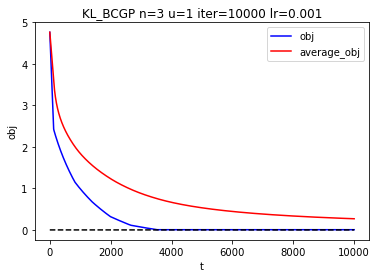

In [9]:
draw_obj_plt(result)

In [10]:
with open('experiment/Orig_BCGP/n_3_u_1_lr0.001_iter10000.pickle', 'rb') as f:
    Orig_BCGP = pickle.load(f)
with open('experiment/KL_BCGP/n_3_u_1_lr0.001_iter10000.pickle', 'rb') as f:
    KL_BCGP = pickle.load(f)
with open('experiment/KL_GD-min/n_3_u_1_lr0.001_iter10000.pickle', 'rb') as f:
    KL_GD_min = pickle.load(f)


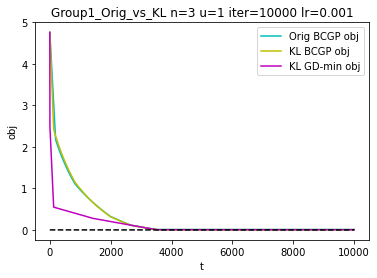

In [11]:
draw_multiple_obj_plt(Orig_BCGP, KL_BCGP, KL_GD_min)